Name : Anish Nair

Registration Number : 200906216





# FORECASTING ENERGY CONSUMPTION

The goal of this notebook is to analyze electrical meter data from non-residential buildings and to forecast it's energy comsumption in the follwing months.
We use two datasets, one containing the electricty meter data and one containing the weather data as it has an impact in the final energy consumption.



## Import relevant python packages

Utilizing electrical meter data, we aim to generate clusters representing typical load profiles for in-depth analysis. Initially, we will load our standard packages to facilitate the process.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

Next let's load all the packages we will need for  analysis

In [6]:
# Importing necessary modules from the scikit-learn library
import sklearn
from sklearn import metrics

# Importing the KNeighborsRegressor class from scikit-learn
from sklearn.neighbors import KNeighborsRegressor

# Importing modules for kmeans clustering from the SciPy library
from scipy.cluster.vq import kmeans, vq, whiten

# Importing the cdist function for calculating distances between points in scipy
from scipy.spatial.distance import cdist

# Importing the NumPy library with alias np
import numpy as np

# Importing the datetime class from the datetime module
from datetime import datetime

## Electricity Prediction for Measurement and Verification


Prediction serves as a prevalent machine learning (ML) approach applied to data related to building energy consumption. This technique proves beneficial for various applications such as anomaly detection, implementing load profile-based building control, and facilitating measurement and verification (M&V) procedures.

The graphic below, sourced from the International Performance Measurement and Verification Protocol (IPMVP), illustrates the application of prediction in M&V. It demonstrates how prediction can be utilized to estimate the energy consumption that would have occurred if an energy-saving intervention had not been implemented



![alt text](https://raw.githubusercontent.com/buds-lab/the-building-data-genome-project/master/docs/edx-graphics/EDX-ML-ScikitLearn-3.png)




## Loading Electricity and Weather Data


In [21]:

elec_all_data = pd.read_csv("electricity_cleaned.csv", index_col='timestamp', parse_dates=True)
#reading the dataset

In [19]:
elec_all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 1578 entries, Panther_parking_Lorriane to Mouse_science_Micheal
dtypes: float64(1578)
memory usage: 211.3 MB


In [22]:
buildingname = 'Panther_office_Hannah'

In [23]:
# Creating a DataFrame named office_example_prediction_data by truncating and selecting data for a specific building 
# The truncation is done to include data from January 1, 2017, and onward
# The data is filled forward using the 'ffill' method to handle any missing values
office_example_prediction_data = pd.DataFrame(elec_all_data[buildingname].truncate(before='2017-01-01')).fillna(method='ffill')

<Axes: xlabel='timestamp'>

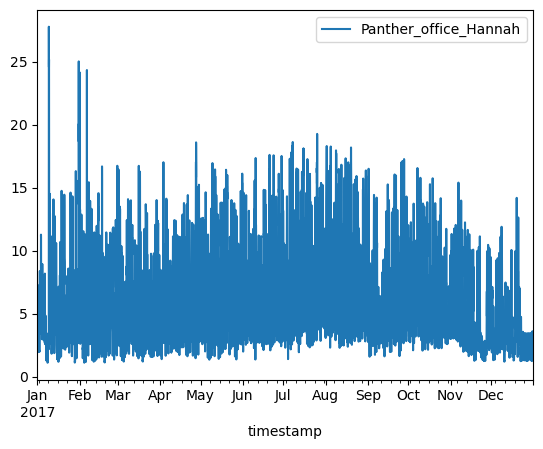

In [24]:
office_example_prediction_data.plot()

In [28]:
weather_data = pd.read_csv("weather.csv", index_col='timestamp', parse_dates=True)

In [29]:
# Extracting weather data for the site with the ID 'Panther' and truncating 
#the data to include dates from January 1, 2017, onwards
weather_data_site = weather_data[weather_data.site_id == 'Panther'].truncate(before='2017-01-01')

In [30]:
weather_data_site.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   site_id         8760 non-null   object 
 1   airTemperature  8760 non-null   float64
 2   cloudCoverage   5047 non-null   float64
 3   dewTemperature  8760 non-null   float64
 4   precipDepth1HR  8752 non-null   float64
 5   precipDepth6HR  329 non-null    float64
 6   seaLvlPressure  8522 non-null   float64
 7   windDirection   8511 non-null   float64
 8   windSpeed       8760 non-null   float64
dtypes: float64(8), object(1)
memory usage: 684.4+ KB


In [31]:
# Resampling the weather data at an hourly frequency and calculating the mean for each hour
weather_hourly = weather_data_site.resample("H").mean()

# Removing outliers by filtering out values below -40 degrees Celsius
weather_hourly_nooutlier = weather_hourly[weather_hourly > -40]

# Filling any remaining gaps in the data by forward-filling missing values
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')

C:\Users\naira\AppData\Local\Temp\ipykernel_35688\3560457145.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weather_hourly = weather_data_site.resample("H").mean()


In [32]:
# Extracting the 'airTemperature' column from the processed weather data, storing it in the 'temperature' variable
temperature = weather_hourly_nooutlier_nogaps["airTemperature"]


<Axes: xlabel='timestamp'>

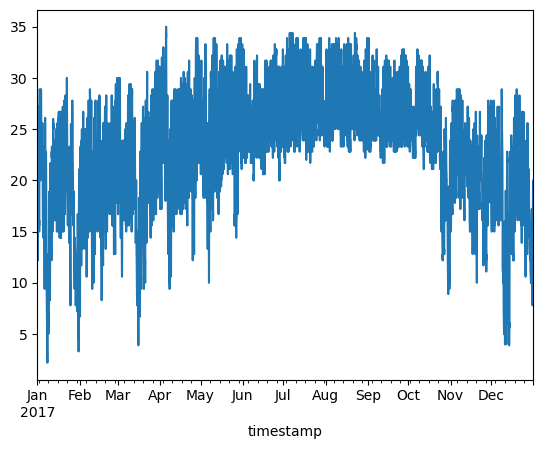

In [33]:
temperature.plot()

## Creating Train and Test Datasets

The model is provided with a dataset intended for training. This training process aims to equip the model to predict a specific objective. In our scenario, we'll utilize a selection of straightforward time series features along with outdoor air temperature to forecast a building's energy consumption.

To illustrate this process, we'll employ data spanning three months, encompassing April, May, and June, to train the model. The objective is to train the model to make predictions for the subsequent month, July.

In [39]:
training_months = [4,5,6]
test_months = [7]

We can divide the data set by using the `datetime index` of the data frame and a function known as `.isin` to extract the months for the model

In [35]:
trainingdata = office_example_prediction_data[office_example_prediction_data.index.month.isin(training_months)]
testdata = office_example_prediction_data[office_example_prediction_data.index.month.isin(test_months)]

In [36]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2184 entries, 2017-04-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Panther_office_Hannah  2184 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


In [38]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2017-07-01 00:00:00 to 2017-07-31 23:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Panther_office_Hannah  744 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


## Encoding Categorical Variables 




In [40]:
# Concatenating dummy variables for each hour of the day
hour_dummies = pd.get_dummies(trainingdata.index.hour)

# Concatenating dummy variables for each day of the week
dayofweek_dummies = pd.get_dummies(trainingdata.index.dayofweek)

# Extracting temperature data for the specified training months
temperature_data = pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)

# Concatenating the extracted features (hour, day of the week, temperature) into the 'train_features' DataFrame
train_features = pd.concat([hour_dummies, dayofweek_dummies, temperature_data], axis=1).dropna()



Dummy variables, also known as indicator variables or binary variables, are a way to represent categorical data
with two or more categories in a numerical format. In the context of machine learning and statistical modeling,
dummy variables are often used to encode categorical features that are not inherently numerical.

In [41]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,0,1,2,3,4,5,6,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,21.7
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,21.0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18.9
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,20.6
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,21.0


## Train a K-Neighbor Model

In [43]:
# Creating a K-Nearest Neighbors (KNN) regression model instance with default parameters
# Fitting the model using the features in train_features and corresponding target values in trainingdata.values
model = KNeighborsRegressor().fit(np.array(train_features), np.array(trainingdata.values))


In [44]:
# Extracting dummy variables for each hour of the day in the testdata index
hour_dummies_test = pd.get_dummies(testdata.index.hour)

# Extracting dummy variables for each day of the week in the testdata index
dayofweek_dummies_test = pd.get_dummies(testdata.index.dayofweek)

# Extracting temperature data for the specified test months
temperature_data_test = pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)

# Concatenating the extracted features (hour, day of the week, temperature) for the test set
# Dropping any rows with missing values
test_features = np.array(pd.concat([hour_dummies_test, dayofweek_dummies_test, temperature_data_test], axis=1).dropna())


## Use the Model to predict for the *Test* period

Then the model is given the `test_features` from the period which we want to predict. 
We can then merge those results and see how the model did

In [45]:
predictions = model.predict(test_features)

In [46]:
# Concatenating the testdata and the predicted values into a DataFrame for comparison
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(predictions, index=testdata.index)], axis=1)


In [47]:
predicted_vs_actual.columns = ["Actual", "Predicted"]

In [48]:
predicted_vs_actual.head()

,Actual,Predicted
timestamp,,
2017-07-01 00:00:00,5.3370,5.49464
2017-07-01 01:00:00,3.8547,5.03418
2017-07-01 02:00:00,5.5751,4.18462
2017-07-01 03:00:00,4.1248,4.01956
2017-07-01 04:00:00,3.3497,5.26522


<Axes: xlabel='timestamp'>

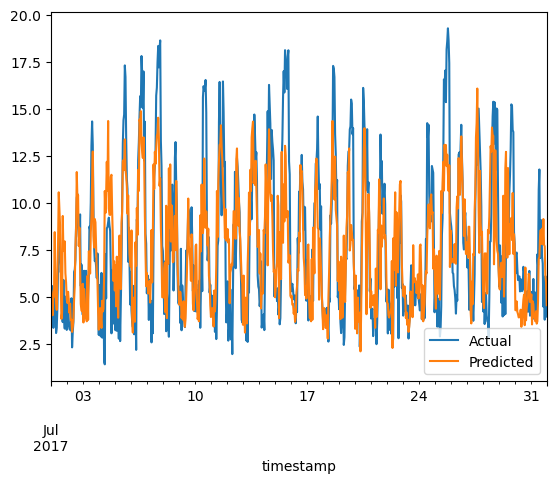

In [49]:
predicted_vs_actual.plot()

In [50]:
trainingdata.columns = ["Actual"]

In [51]:
# Concatenating the trainingdata with the DataFrame containing both predicted and actual values
# The 'sort=True' parameter ensures the resulting DataFrame is sorted by index
predicted_vs_actual_plus_training = pd.concat([trainingdata, predicted_vs_actual], sort=True)


<Axes: xlabel='timestamp'>

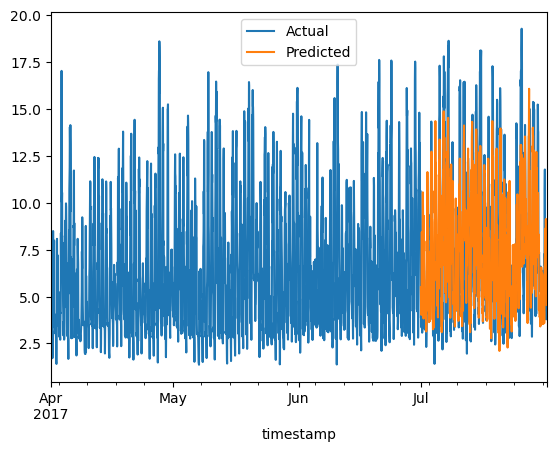

In [52]:
predicted_vs_actual_plus_training.plot()

## Evaluation metrics

To quantitatively assess the model's performance, we can employ different evaluation metrics to gauge its accuracy 
compared to actual outcomes. Specifically, we will utilize the Mean Absolute Percentage Error (MAPE) as an error metric 
in this context.

In [53]:
# Calculate the absolute errors
errors = abs(predicted_vs_actual['Predicted'] - predicted_vs_actual['Actual'])
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / predicted_vs_actual['Actual']))

In [54]:
MAPE

33.85057697955611

## Conclusion

The project demonstrates the application of machine learning, specifically KNN regression, for forecasting energy consumption 
in non-residential buildings. The chosen evaluation metric (MAPE) provides a quantitative measure of the model's accuracy in 
predicting energy consumption during the test period. Further analysis, interpretation, and potential optimization of the model 
can be conducted based on these results. The project serves as a foundation for leveraging machine learning techniques in 
energy consumption forecasting within the built environment.